- Feature engineering
- Feature selection
- Hyperparameter tuning (random and grid search etc)
- Evaluation scores
- Presentation and documentation

### You may refer to the code section on how other people are doing their analysis and baseline model building. The data for training is application_train.csv for training and the data for testing is application_test.csv for evaluation. The team formation is only for discussion and presentation purposes, you need to do all these tasks by yourself.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/application_train.csv')
print(df.shape)

y = df['TARGET']
train_df = df.drop(columns = 'TARGET')


(307511, 122)


# Undersampling

In [ ]:
# rus = RandomUnderSampler(random_state=0)
# train, y = rus.fit_resample(train, y_train)

# print(train.shape, y.shape)

# Encoding

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_df:
    if train_df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_df[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_df[col])
            
            # Transform both training and testing data
            train_df[col] = le.transform(train_df[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

train_df = pd.get_dummies(train_df)

print('Train set shape after dummies:', train_df.shape)


3 columns were label encoded.
Train set shape after dummies: (307511, 242)


# Anomality Reduction

In [ ]:
# Create an anomalous flag column
train_df['DAYS_EMPLOYED_ANOM'] = train_df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


In [ ]:
train_df, test_df, y_train, y_test = train_test_split(train_df, y, test_size=0.33, random_state=42)

train_df.insert(1, 'TARGET', y_train)
test_df.insert(1, 'TARGET', y_test)

test_original_X = test_df.copy()
test_original_Y = y_test.copy()

print(train_df.shape)
print(test_df.shape)

# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/application_test.csv')
# print(test_df.shape)

train_df.head()

(206032, 244)
(101479, 244)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,...,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
290720,436794,0,0,0,1,0,180000.0,835380.0,33259.5,675000.0,0.018029,-17253,-4267.0,-5321.0,-762,NaN,1,1,0,1,0,0,2.0,3,3,12,0,0,0,0,0,0,0.682599,0.431879,0.165407,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
219406,354174,0,0,1,1,0,225000.0,1256400.0,40657.5,900000.0,0.010556,-20050,-9003.0,-5354.0,-3525,31.0,1,1,0,1,0,0,2.0,3,3,11,0,0,0,0,0,0,NaN,0.518029,NaN,0.0278,0.0466,0.9776,0.7552,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,False
238458,376164,0,0,0,1,1,225000.0,387144.0,30717.0,342000.0,0.046220,-13419,-968.0,-1303.0,-1049,NaN,1,1,0,1,0,1,2.0,1,1,11,0,1,1,0,0,0,0.510589,0.713355,0.454321,0.1026,0.0684,0.9771,0.6872,0.0232,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,False
189443,319651,0,0,0,0,0,180000.0,450000.0,33646.5,450000.0,0.026392,-19217,-7371.0,-5254.0,-2757,NaN,1,1,1,1,1,0,2.0,2,2,16,0,0,0,0,0,0,NaN,0.686872,0.736623,0.1485,NaN,0.9841,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,False
32184,137317,0,0,0,1,0,108000.0,288873.0,14179.5,238500.0,0.003813,-21789,NaN,-1508.0,-4151,NaN,1,0,0,1,0,0,2.0,2,2,10,0,0,0,0,0,0,0.544829,0.149870,0.528093,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


# Aligning

In [ ]:
train_labels = train_df['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train_df, test_df = train_df.align(test_df, join = 'inner', axis = 1)

# Add the target back in
train_df['TARGET'] = train_labels

print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (206032, 244)
Testing Features shape:  (101479, 244)


# Baseline with logistic regression

In [ ]:
# Drop the target from the training data
train = train_df.drop(columns = ['TARGET'])
test_df = test_df.drop(columns = ['TARGET'])
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = test_df.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (206032, 243)
Testing data shape:  (101479, 243)


In [ ]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
y_score = log_reg.fit(train, train_labels)

In [ ]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:,1]
print(log_reg_pred)

log_reg_y = log_reg.predict(test)
print(log_reg_y)

[0.10669516 0.06811094 0.09358385 ... 0.09939854 0.09808436 0.07792939]
[0 0 0 ... 0 0 0]


# Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100)

# Train on the training data
random_forest.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Make predictions on the test data
desc_tree_pred = random_forest.predict_proba(test)[:,1]
print(desc_tree_pred)

desc_tree_y = random_forest.predict(test)
print(desc_tree_y)

[0.27 0.07 0.09 ... 0.13 0.15 0.01]
[0 0 0 ... 0 0 0]


# Confusion Matrix

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     93362
           1       0.00      0.00      0.00      8117

    accuracy                           0.92    101479
   macro avg       0.46      0.50      0.48    101479
weighted avg       0.85      0.92      0.88    101479



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[93362     0]
 [ 8117     0]]


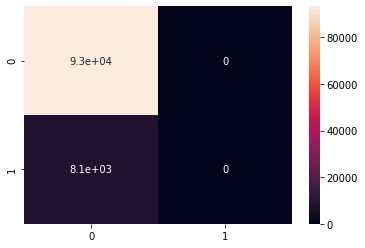

In [ ]:
print(classification_report(y_test, log_reg_y))
print(confusion_matrix(y_test, log_reg_y))

sns.heatmap(confusion_matrix(y_test, log_reg_y), annot=True)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     93362
           1       0.70      0.00      0.00      8117

    accuracy                           0.92    101479
   macro avg       0.81      0.50      0.48    101479
weighted avg       0.90      0.92      0.88    101479

[[93359     3]
 [ 8110     7]]


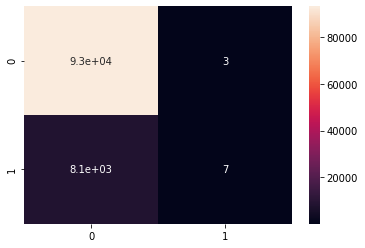

In [ ]:
print(classification_report(y_test, desc_tree_y))
print(confusion_matrix(y_test, desc_tree_y))

sns.heatmap(confusion_matrix(y_test, desc_tree_y), annot=True)

# ROC Curve for Logistic and Random Forest

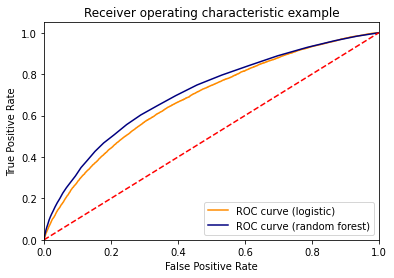

In [ ]:
# Compute ROC curve and ROC area for each class
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg_pred)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_tree, tpr_tree, _ = roc_curve(y_test, desc_tree_pred)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure()
plt.plot(fpr_log, tpr_log, color='darkorange',label='ROC curve (logistic)')
plt.plot(fpr_tree, tpr_tree, color='navy',label='ROC curve (random forest)')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()